# Day 5 MNIST demo
##### written by LarryHYQ

## TRAIN

### Import some necessary packages

In [1]:
import os
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from einops.layers.torch import Rearrange
from tqdm.notebook import tqdm
import IPython.display as display
%matplotlib inline
from matplotlib import pyplot as plt
import PIL

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

### Build the MLP

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

### Build the ConvNet without BN

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 15, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(15, 25, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(25, 50, kernel_size=4, padding=1)
        self.conv3_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(450, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        out = self.fc3(x)
        return out

### Build the ConvNet with BN

In [4]:
class ConvNet_BN(nn.Module):
    def __init__(self):
        super(ConvNet_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 15, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(15)
        self.conv2 = nn.Conv2d(15, 25, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(25)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(25, 50, kernel_size=4, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(50)
        self.conv3_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(450, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2_drop(self.conv2(x))), 2))
        x = F.relu(F.max_pool2d(self.bn3(self.conv3_drop(self.conv3(x))), 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        out = self.fc3(x)
        return out

### Setting some Paeameter

In [27]:
lr = 0.001  # learning rate
batch_size_train = 600  # batch_size for train
batch_size_test = 1000  # batch_size for test
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
all_epochs = 10
# writer = SummaryWriter("runs/MNIST_demo_mlp_experiment")
# writer = SummaryWriter("runs/MNIST_demo_cnn_experiment")
writer = SummaryWriter("runs/MNIST_demo_cnnbn_experiment")

### Setting GPU or CPU

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Preparing Data

In [29]:
def prepare_data():
    global trainset, trainloader, testset, testloader
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size_train, shuffle=True, num_workers=0)

    testset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size_test, shuffle=False, num_workers=0)

### Setting the Model

In [30]:
def set_model():
    global net, optimizer, criterion, start_epoch, best_acc
    print('==> Building model..')
    # net = MLP() # 前馈神经网络
    # net = ConvNet() # 不带批量归一化的卷积神经网络
    net = ConvNet_BN() # 带批量归一化的卷积神经网络
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    resume_flag = input("Whether to continue training?(Y/N)\n")

    if (resume_flag == "Y") or (resume_flag == "y"):
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        last_checkpoint = torch.load('./checkpoint/mnist_demo_last.pth')
        best_checkpoint = torch.load('./checkpoint/mnist_demo_best.pth')
        net.load_state_dict(last_checkpoint['net'])
        best_acc = best_checkpoint['acc']
        start_epoch = last_checkpoint['epoch'] + 1

    criterion = F.cross_entropy
    optimizer = optim.Adam(net.parameters(), lr=lr)

### Plot on TensorBoard

In [31]:
def plot_tb():
    images, labels = next(iter(trainloader))
    # images = images.view(images.size(0), -1) # 使用前馈神经网络需要将图像铺平，卷积注释掉
    grid = torchvision.utils.make_grid(images)
    writer.add_image("image", grid)
    writer.add_graph(net, images)
    writer.close()

### Training

In [32]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader), desc=f'TRAIN Epoch {epoch}',total=len(trainloader))
    for batch_idx, (inputs, targets) in pbar:
        # inputs = inputs.view(inputs.size(0), -1) # 使用前馈神经网络需要将图像铺平，卷积注释掉
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        pbar.set_postfix({"Loss":f"{(train_loss/(batch_idx+1)):.3f}","Acc":f"{100*correct/total:.3f} ({correct}/{total})"})
    writer.add_scalar("TRAIN/Loss", (train_loss/(batch_idx+1)), epoch)
    writer.add_scalar("TRAIN/Acuracy", (correct/total), epoch)
    writer.close()

### Testing

In [33]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(testloader), desc=f'TEST Epoch {epoch}',total=len(testloader))
        for batch_idx, (inputs, targets) in pbar:
            # inputs = inputs.view(inputs.size(0), -1) # 使用前馈神经网络需要将图像铺平，卷积注释掉
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({"Loss":f"{(test_loss/(batch_idx+1)):.3f}","Acc":f"{100*correct/total:.3f} ({correct}/{total})"})
        writer.add_scalar("TEST/Loss", (test_loss/(batch_idx+1)), epoch)
        writer.add_scalar("TEST/Accuracy", (correct/total), epoch)   
        writer.close()
        
    # Save checkpoint.
    acc = 100.*correct/total
    print('Saving the last..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/mnist_demo_last.pth')
    print("The last Acc:" + str(acc))
    if acc > best_acc:
        print('Saving the best..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
 
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/mnist_demo_best.pth')
        best_acc = acc
    print("The best Acc:" + str(best_acc))

### Main

In [34]:
prepare_data()
set_model()
plot_tb()

==> Preparing data..
==> Building model..


Whether to continue training?(Y/N)
 N


In [35]:
for epoch in range(start_epoch, start_epoch + all_epochs):
    train(epoch)
    test(epoch)
    display.clear_output(wait=True)

TRAIN Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

TEST Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Saving the last..
The last Acc:97.63
The best Acc:97.79


### Predict

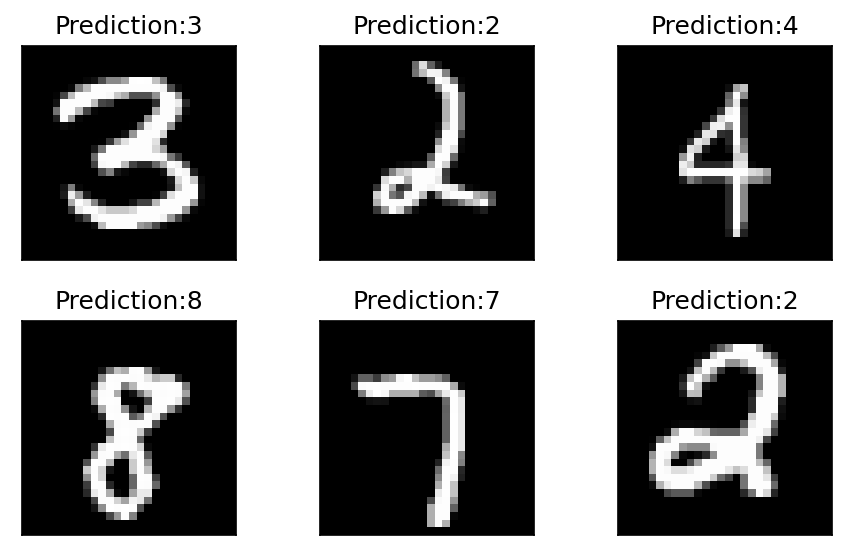

In [36]:
examples = enumerate(testloader)
batch_idx, (example_data, example_target) = next(examples)
example_data_temp = example_data # 没什么重要的，主要作用少改点注释
with torch.no_grad():
    # example_data_temp = example_data.view(example_data.size(0), -1) # 使用前馈神经网络需要将图像铺平，卷积注释掉
    output = net(example_data_temp.to(device))

plt.figure(dpi=150)
for i in range(6):
    cont = i + np.random.randint(len(example_data)-6)
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[cont][0], cmap='gray', interpolation='none')
    plt.title("Prediction:{}".format(output.data.max(1, keepdim=True)[1][cont].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()